In [56]:
import re
import json
import numpy as np
from shapely import wkt
from PIL import Image, ImageDraw
import os

PATH_LABELS = "../dataset/tier3/labels/"
PATH_IMAGES = "../dataset/tier3/images/"
PATH_TARGETS = "../dataset/tier3/targets/"

# Map subtypes to mask values
SUBTYPE_TO_VALUE = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4
}

# Image size
IMG_WIDTH, IMG_HEIGHT = 1024, 1024

def extract_bounds_from_json(data):
    """Extract min/max longitude and latitude from WKT polygons."""
    all_coords = []

    for feature in data['features']['lng_lat']:
        wkt_str = feature['wkt']
        coords = re.findall(r'(-?\d+\.\d+)\s+(-?\d+\.\d+)', wkt_str)
        coords = [(float(lon), float(lat)) for lon, lat in coords]
        all_coords.extend(coords)

    lons = [lon for lon, _ in all_coords]
    lats = [lat for _, lat in all_coords]

    return min(lons), max(lons), min(lats), max(lats)

def geo_to_pixel(lon, lat, min_lon, max_lon, min_lat, max_lat):
    """Convert geo coordinates to image pixel coordinates."""
    x = (lon - min_lon) / (max_lon - min_lon) * IMG_WIDTH
    y = (max_lat - lat) / (max_lat - min_lat) * IMG_HEIGHT
    return (x, y)

def draw_polygon(draw, polygon, value, bounds):
    """Draw a filled polygon on the image."""
    min_lon, max_lon, min_lat, max_lat = bounds
    pixel_coords = [geo_to_pixel(x, y, min_lon, max_lon, min_lat, max_lat) for x, y in polygon.exterior.coords]
    draw.polygon(pixel_coords, fill=value)

def create_mask_from_json(json_path, output_path="mask.png"):
    """Main function to create and save a mask image from JSON."""
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract bounds from the data (no need to pass file path, just pass the loaded data)
    min_lon, max_lon, min_lat, max_lat = extract_bounds_from_json(data)
    bounds = (min_lon, max_lon, min_lat, max_lat)

    mask = Image.new("L", (IMG_WIDTH, IMG_HEIGHT), 0)
    draw = ImageDraw.Draw(mask)

    for feature in data["features"]["lng_lat"]:
        subtype = feature["properties"].get("subtype", "").lower()
        if subtype not in SUBTYPE_TO_VALUE:
            continue

        value = SUBTYPE_TO_VALUE[subtype]
        geom = wkt.loads(feature["wkt"])

        if geom.is_valid and geom.geom_type == "Polygon":
            draw_polygon(draw, geom, value, bounds)

    mask.save(output_path)
    print(f"Saved mask to {output_path}")


In [57]:
json_file_list = [file for file in os.listdir(PATH_LABELS) 
         if os.path.isfile(os.path.join(PATH_LABELS, file)) and not file.endswith('.Identifier')]
print(json_file_list)
print(len(json_file_list))

['portugal-wildfire_00001361_post_disaster.json', 'portugal-wildfire_00000310_post_disaster.json', 'pinery-bushfire_00000253_pre_disaster.json', 'pinery-bushfire_00001118_pre_disaster.json', 'pinery-bushfire_00001024_post_disaster.json', 'portugal-wildfire_00000472_post_disaster.json', 'portugal-wildfire_00001578_pre_disaster.json', 'pinery-bushfire_00001338_pre_disaster.json', 'woolsey-fire_00000635_post_disaster.json', 'pinery-bushfire_00001292_pre_disaster.json', 'lower-puna-volcano_00000030_pre_disaster.json', 'nepal-flooding_00000030_pre_disaster.json', 'tuscaloosa-tornado_00000161_pre_disaster.json', 'woolsey-fire_00000076_pre_disaster.json', 'woolsey-fire_00000787_pre_disaster.json', 'tuscaloosa-tornado_00000107_pre_disaster.json', 'portugal-wildfire_00000760_post_disaster.json', 'portugal-wildfire_00001132_pre_disaster.json', 'portugal-wildfire_00000942_post_disaster.json', 'moore-tornado_00000112_post_disaster.json', 'pinery-bushfire_00001133_post_disaster.json', 'pinery-bushf

In [58]:
for json_file in json_file_list:
    json_path = os.path.join(PATH_LABELS, json_file)
    output_path = os.path.join(PATH_TARGETS, json_file.replace(".json", "_target.png"))
    print(json_path)
    print(output_path)
    create_mask_from_json(json_path, output_path)

../dataset/tier3/labels/portugal-wildfire_00001361_post_disaster.json
../dataset/tier3/targets/portugal-wildfire_00001361_post_disaster_target.png


ValueError: min() arg is an empty sequence

In [2]:
import numpy as np
import cv2

def overlay_masks_on_image(image, mask, alpha=0.4):
    """
    Overlays a color image with a 5-channel mask.
    
    Parameters:
        image (np.ndarray): RGB image of shape (X, Y, 3), dtype=uint8.
        mask (np.ndarray): One-hot encoded mask of shape (X, Y, 5), dtype=uint8 or bool.
        alpha (float): Transparency of the mask overlay.
        
    Returns:
        np.ndarray: Image of shape (X, Y, 3) with mask overlay.
    """
    # Define RGBA colors for each layer (skip layer 0: transparent)

    colors = {
        1: (0, 255, 255),    # Cyan
        2: (255, 255, 0),    # Yellow
        3: (255, 165, 0),    # Orange
        4: (255, 0, 0),      # Red
    }

    overlay = image.copy()

    for i in range(1, 5):  # Skip channel 0 (transparent)
        mask_layer = mask[:, :, i]
        color = np.array(colors[i], dtype=np.uint8)

        # Create a colored layer with the mask
        color_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            color_mask[:, :, c] = color[c] * mask_layer

        # Blend the color mask with the original image
        overlay = np.where(mask_layer[..., None], 
                           (1 - alpha) * overlay + alpha * color_mask,
                           overlay)

    return overlay.astype(np.uint8)


(-0.5, 1023.5, 1023.5, -0.5)

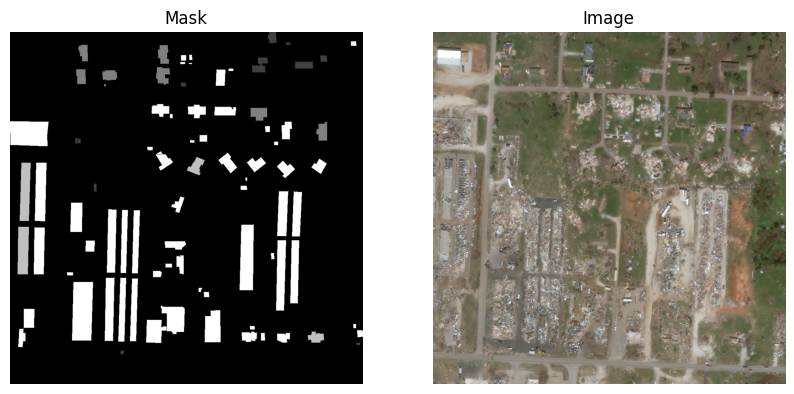

In [8]:
import matplotlib.pyplot as plt

image_post = plt.imread("../dataset/tier3/images/joplin-tornado_00000088_post_disaster.png")

mask = plt.imread("mask.png")
# Display the mask image
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')  # Hide axes
plt.subplot(1, 2, 2)
plt.title("Image")
plt.imshow(image_post)
plt.axis('off')  # Hide axes

[0. 1. 2. 3. 4.]


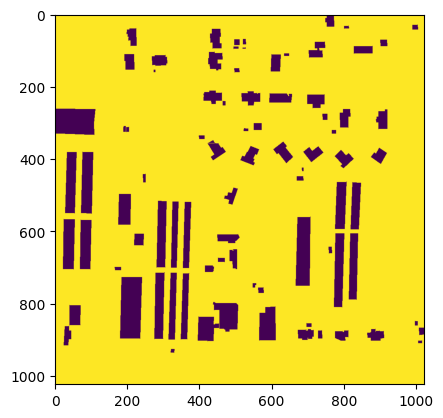

In [32]:
from tensorflow.keras.utils import to_categorical
mask3 = np.array(mask*255)
mask2 = to_categorical(mask3, num_classes=5)

plt.imshow(mask2[:, :, 0])

(-0.5, 1023.5, 1023.5, -0.5)

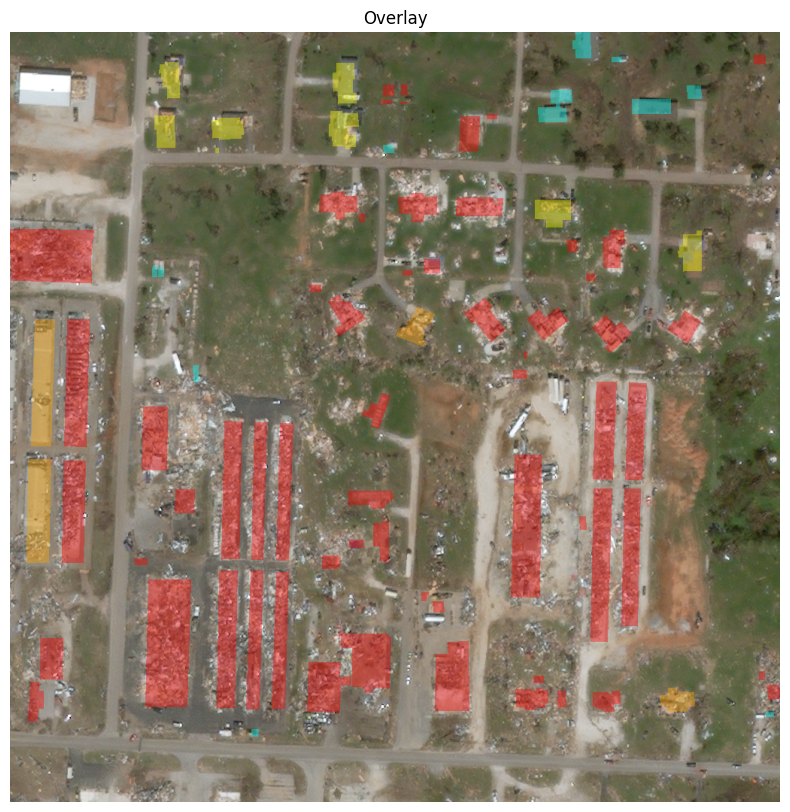

In [34]:
a = overlay_masks_on_image(image_post*255, mask2, alpha=0.4)
plt.figure(figsize=(10,10))
plt.title("Overlay")
plt.imshow(a)
plt.axis('off')  # Hide axes